# 加州房价预测

In [17]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
train_set = pd.read_csv('../data/train.csv')
test_set = pd.read_csv('../data/test.csv')
train_set.shape, test_set.shape

((47439, 41), (31626, 40))

In [7]:
# 选取所有数值类型的特征
numeric_features = all_set.dtypes[all_set.dtypes != 'object'].index
print(numeric_features)
# 对这些数值特征应用标准化转换
all_set[numeric_features] = all_set[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
# 标准化后特征均值变为0,可以直接用0填充原数据中的空值
all_set[numeric_features] = all_set[numeric_features].fillna(0)
all_features = all_set.loc[:, ["Year built", "Lot", "Bathrooms", "Full bathrooms", "Total spaces", "High School Score","Tax assessed value", "Annual tax amount", "Listed Price", "Last Sold Price", "Zip"]]

Index(['Year built', 'Lot', 'Bathrooms', 'Full bathrooms',
       'Total interior livable area', 'Total spaces', 'Garage spaces',
       'Elementary School Score', 'Elementary School Distance',
       'Middle School Score', 'Middle School Distance', 'High School Score',
       'High School Distance', 'Tax assessed value', 'Annual tax amount',
       'Listed Price', 'Last Sold Price', 'Zip'],
      dtype='object')


In [8]:
# dummy_na=True表示将缺失值也编码为一个独热列
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(79065, 11)

In [15]:
n_train = train_set.shape[0] # 训练数据个数
# 将训练数据和测试数据拆分为特征和标签
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_label.values.reshape(-1, 1), dtype=torch.float32)
train_features.shape, test_features.shape, train_labels.shape

(torch.Size([47439, 11]), torch.Size([31626, 11]), torch.Size([47439, 1]))

In [24]:
loss = nn.MSELoss()  # 损失函数
in_features = train_features.shape[1]  # 输入特征个数
# 生成网络
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 32),
                    nn.ReLU(),
                    nn.Linear(32, 16),
                    nn.ReLU(),
                    nn.Linear(16, 1)) # 多层感知机
    return net

In [25]:
def log_rmse(net, features, labels):
  """
  计算网络预测和标签之间的对数均方根误差。

  参数：
    net (nn.Module): 要评估的网络。
    features (Tensor): 网络的输入特征。
    labels (Tensor): 网络的标签。

  返回：
    Tensor: 对数均方根误差。
  """

  # 将小于 1 的预测值设置为 1，以进一步稳定对数。
  # 函数将 net(features) 中的所有元素限制在范围 [1, float('inf')] 内(为下面求log做铺垫)
  clipped_preds = torch.clamp(net(features), 1, float('inf'))

  # 计算对数均方根误差。
  rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))

  # 返回对数均方根误差。
  return rmse.item()

In [26]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [27]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    # //表示地板除法(floor division),它会对结果进行下取整
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [28]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1},训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1,训练log rmse1.395431, 验证log rmse1.448594
折2,训练log rmse1.390277, 验证log rmse1.473688
折3,训练log rmse1.398863, 验证log rmse1.444228
折4,训练log rmse1.416580, 验证log rmse1.390677
折5,训练log rmse1.435967, 验证log rmse1.271506
5-折验证: 平均训练log rmse: 1.407424, 平均验证log rmse: 1.405738


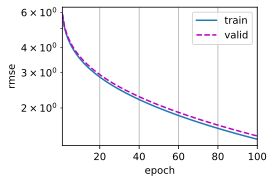

In [29]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [30]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse:{float(train_ls[-1]):f}')
    # 将网络应用于测试集
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('../data/samples_submission.csv', index=False)

In [31]:
train_and_pred(train_features, test_features, train_labels,
               test_data, num_epochs, lr, weight_decay, batch_size)

NameError: name 'test_data' is not defined